## 인프런 2020년 새해 다짐 이벤트 댓글 분석
* https://www.inflearn.com/pages/newyear-event-20200102
* 영상 튜토리얼 : [댓글 수백 수천개 분석하기?! [1/5] 이벤트 데이터 크롤링 feat. 인프런 새해 다짐 이벤트 - YouTube](https://www.youtube.com/watch?v=OUSwQk79H8I&list=PLaTc2c6yEwmohRzCxWQqJ7Z9aqc-sQ5gC)

## 기획자나 마케터가 되어 이벤트 댓글을 분석해 보자!
### 내가 만약 수백 수천개의 댓글을 다 읽어봐야 한다면?
### 댓글 속에 제품에 대한 관심을 빈도수로 추출해야 한다면?
* 쇼핑몰에서 제품 관련 이벤트 진행시 어떤 제품을 고객이 선호하는지 알고 싶다면?
* 고객 DB와 연계할 수 있다면 이벤트 혹은 마케팅 세그먼트로 활용해 볼 수도 있지 않을까?

### 향후 마케팅이나 전략을 어떻게 세워야 할까?

## 라이브러리 로드

In [49]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

%matplotlib inline
# 시각화 결과가 선명하게 표시되도록
%config InlineBackend.figure_format = 'retina'

## 시각화를 위한 한글폰트 설정

In [50]:
# Window 한글폰트 설정
plt.rc("font", family="Malgun Gothic")
# Mac 한글폰트 설정
# plt.rc("font", family="AppleGothic")
plt.rc('axes', unicode_minus=False)

## 크롤링한 파일 로드하기

In [51]:
# df 라는 변수에 이벤트 댓글 파일을 로드합니다.
df = pd.read_csv('data/inflearn-event.csv')
df.shape

(2449, 1)

In [52]:
# head 로 미리보기 합니다.
df.head()

,text
0,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...
1,"2020년 목표: C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는..."
2,2020년 목표 : 리액트 공부하기
3,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급
4,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!


In [53]:
# tail 로 미리보기 합니다.
df.tail()

,text
2444,"작년 한해도 일이 바쁘다, 야근해서 힘들다는 핑계로 김영한님의 JPA 강의를 또 스..."
2445,저는 졸업을 1년 남기고 있는 컴퓨터공학과 학생입니다. 졸업 프로젝트로 웹/앱 개발...
2446,"에프터 이펙트를 써본 적은 있는데, 매번 기초만 배우다 말았어요. 이걸 할 줄 안다..."
2447,저번에 인프런에서 페이스북 마케팅 강의를 듣고 많은 도움을 받았습니다. 마케팅 업무...
2448,인프런 0호 팀원이에요!\n그동안 서비스 개발 때문에 js 를 많이 했었는데 앞으론...


## 데이터 전처리

### 네트워크 오류 등으로 발생한 중복 입력 값을 제거
* 빈도 수 중복을 방지하기 위해

In [54]:
# drop_duplicates 를 통해 중복을 제거합니다. 이때 마지막 글을 남깁니다.
df[df.duplicated()].shape

(38, 1)

In [55]:
df = df.drop_duplicates().copy()
df.shape

(2411, 1)

### 원본은 따로 보존

In [56]:
# 전처리 전에 원본을 보존하기 위해 origin_text 라는 컬럼에 복사해 둡니다.

df['origin_text'] = df['text']
df[['text', 'origin_text']].head()

,text,origin_text
0,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...
1,"2020년 목표: C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는...","2020년 목표: C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는..."
2,2020년 목표 : 리액트 공부하기,2020년 목표 : 리액트 공부하기
3,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급
4,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!


### 소문자 변환

In [57]:
# "text" 파이썬은 대소문자를 구분하기 때문에 데이터 필터링을 위해 대문자를 모두 소문자로 변경

df['text'] = df['text'].str.lower()

0       2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...
1       2020년 목표: c++ 열심히 공부해서, 학교에서 꼭 a 맞기..!! \n관심있는...
2                                     2020년 목표 : 리액트 공부하기
3                   40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급
4                         2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!
                              ...                        
2444    작년 한해도 일이 바쁘다, 야근해서 힘들다는 핑계로 김영한님의 jpa 강의를 또 스...
2445    저는 졸업을 1년 남기고 있는 컴퓨터공학과 학생입니다. 졸업 프로젝트로 웹/앱 개발...
2446    에프터 이펙트를 써본 적은 있는데, 매번 기초만 배우다 말았어요. 이걸 할 줄 안다...
2447    저번에 인프런에서 페이스북 마케팅 강의를 듣고 많은 도움을 받았습니다. 마케팅 업무...
2448    인프런 0호 팀원이에요!\n그동안 서비스 개발 때문에 js 를 많이 했었는데 앞으론...
Name: text, Length: 2411, dtype: object

In [58]:
# 같은 의미의 단어를 하나로 통일 예) python => 파이썬
# replace 는 텍스트가 완전히 일치될 때만 사용할 수 있습니다.
# 일부만 일치한다면 str.replace 를 사용하면 원하는 텍스트로 변경이 가능합니다.

df['text'] = df['text'].str.replace('python', '파이썬')
df['text'] = df['text'].str.replace('java', '자바')
df['text'] = df['text'].str.replace('react', '리액트')
df['text'] = df['text'].str.replace('node.js', '노드')

### 텍스트로 관심 강의 분리

In [59]:
# 이 이벤트에는 "관심강의"라는 텍스트가 있습니다.
# "관심강의"를 기준으로 텍스트를 분리하고 관심강의 뒤에 있는 텍스트를 가져옵니다.
# 대부분 "관심강의"라는 텍스트를 쓰고 뒤에 강의명을 쓰기 때문입니다.
# 전처리한 내용은 실수를 방지하기 위해 "course" 라는 새로운 컬럼에 담습니다.
# "관심 강의", "관심 강좌" 에 대해서도 똑같이 전처리 합니다.
# ":" 특수문자를 빈문자로 바꿔줍니다.

df[df['text'].str.contains('관심강좌')].shape

(28, 2)

In [60]:
# "text", "course" 전처리 내용 미리보기

df['course'] = df['text'].apply(lambda x : x.split('관심강의')[-1])
df['course'] = df['course'].apply(lambda x : x.split('관심 강의')[-1])
df['course'] = df['course'].apply(lambda x : x.split('관심강좌')[-1])
df['course'] = df['course'].apply(lambda x : x.split('관심 강좌')[-1])
df['course'] = df['course'].str.replace(':', '').str.strip()

In [61]:
df[['text','course']].head()

,text,course
0,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...,2020년 목표 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 강...
1,"2020년 목표: C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는...","2020년 목표 C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는 ..."
2,2020년 목표 : 리액트 공부하기,2020년 목표 리액트 공부하기
3,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급,40대 프로그래밍 시작! 우리를 위한 프로그래밍 파이썬 중급
4,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!,2020년 목표 돌머리 비전공자가 멋진 전공자 되기!


## 띄어 쓰기를 제거한 텍스트에서 키워드 추출
* TIOBE 프로그래밍 언어 순위 : [index | TIOBE - The Software Quality Company](https://www.tiobe.com/tiobe-index/?fbclid=IwAR34dJfgDHq2DK0C6X3g8IsUno2NhOiikMyxT6fw9SoyujFhy5FPvQogMoA)

In [62]:
# 특정 키워드가 들어가는 댓글을 찾습니다.
search_keyword = ['머신러닝', '딥러닝', '파이썬', '판다스', '공공데이터',
                  'django', '크롤링', '시각화', '데이터분석', 
                  '웹개발', '엑셀', 'c', '자바', '자바스크립트', 
                  'node', 'vue', '리액트', 'r']

# for 문을 통해 해당 키워드가 있는지 여부를 True, False값으로 표시하도록 합니다.
# 키워드에 따라 컬럼을 새로 만듭니다.
for lang in search_keyword:
    df[lang] = df['course'].str.contains(lang)

In [63]:
# 미리보기 합니다.

df[search_keyword].head()

,머신러닝,딥러닝,파이썬,판다스,공공데이터,django,크롤링,시각화,데이터분석,웹개발,엑셀,c,자바,자바스크립트,node,vue,리액트,r
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [64]:
# 파이썬|공공데이터|판다스 라는 텍스트가 들어가는 데이터가 있는지 찾습니다.
df['course'].str.contains('파이썬|공공데이터|판다스').sum()

393

In [65]:
# 결과를 모두 더하면 해당 키워드의 등장 빈도수를 카운트 할 수 있습니다.
# search_keyword 컬럼만 가져와서 빈도수를 sum으로 더합니다.

df[search_keyword].sum().sort_values(ascending=False)

r         426
파이썬       392
c         294
자바        251
머신러닝      132
리액트        69
자바스크립트     57
크롤링        56
딥러닝        52
vue        42
시각화        30
웹개발        26
데이터분석      24
엑셀         18
node       16
공공데이터      12
판다스         4
django      3
dtype: int64

In [67]:
# 공공데이터 텍스트가 들어가는 문장만 찾습니다.
# pandas 를 통해 볼때 문장이 길면 끝까지 보이지 않습니다.
# 문장의 전체를 보기 위해 for문을 통해 해당 텍스트를 순회하며 출력합니다.
# 이 때, 데이터 사이에 ------ 줄로 구분해서 표시하도록 합니다.

course_test = df.loc[df['공공데이터'], 'course']

for t in course_test:
    print(t)
    print('-'*20)

프로그래밍 시작하기  파이썬 입문, 공공데이터로 파이썬 데이터 분석 시작하기
파이썬의 고수가 되고싶어요
--------------------
프로그래밍 시작하기  파이썬 입문, 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
공공데이터로 파이썬 데이터 분석 시작하기
--------------------
공공데이터로 파이썬 데이터 분석 시작하기
--------------------
공공데이터로 파이썬 데이터 분석 시작하기
--------------------
공공데이터로 파이썬 데이터 분석 시작하기
--------------------
공공데이터로 파이썬 데이터 분석 시작하기
--------------------
공공데이터로 파이썬 데이터분석 시작하기, DATABASE 1&2 - MySQL
--------------------
공공데이터로 파이썬 데이터 분석 시작하기
--------------------
공공데이터로 분석하기
--------------------
공공데이터로 파이썬 데이터 분석 시작하기
--------------------
공공데이터로 파이썬 데이터 분석 시작하기
--------------------


## 판다스 단어가 들어가는 텍스트만 찾기
* 이미 str.contains 를 통해 판다스가 들어가는 텍스트에 대해 컬럼을 만들어 놨습니다. 이 값이  True 라면 판다스 강좌 입니다.

In [68]:
# pandas 라는 텍스트가 들어가는 내용만 찾습니다.
df.loc[df['course'].str.contains('pandas|판다스'),'text']
# df['course'].str.contains('[pandas]')

541     2020년에는 데이터분석 관련한 실력을 쌓고싶습니다!\n#관심강의 : 파이썬, 판다...
690     취미로 안드로이드 개발하는 사람입니다. 자바로 작성하다 보니, kotlin이 안드로...
758     pandas 라입러리에 관심이 많아서 배워보려 합니다 #관심강의 : 박조은 - pa...
1237      2020년!! 올 해는 빅데이터 분석 전문가 되기!!\n#관심강의 : 파이썬, 판다스
2147    2020년 목표  파이썬 을  활용해  데이터 분석 작업을 진행하고 싶습니다.  관...
2365    저는 백세시대에 조금 더 오랫동안 IT일을 하기위해서 IT전략기획에서 데이터분석가로...
Name: text, dtype: object

## 빈도수 계산을 위한 텍스트 데이터 벡터화
* BOW 단어 가방에 단어를 토큰화 해서 담아줌

### BOW(bag of words)
* 가장 간단하지만 효과적이라 널리쓰이는 방법
* 장, 문단, 문장, 서식과 같은 입력 텍스트의 구조를 제외하고 각 단어가 이 말뭉치에 얼마나 많이 나타나는지만 헤아립니다.
* 구조와 상관없이 단어의 출현횟수만 세기 때문에 텍스트를 담는 가방(bag)으로 생각할 수 있습니다.
* BOW는 단어의 순서가 완전히 무시 된다는 단점이 있다. 예를 들어 의미가 완전히 반대인 두 문장이 있다고 합니다.
    - `it's bad, not good at all.` 
    - `it's good, not bad at all.` 
* 위 두 문장은 의미가 전혀 반대지만 완전히 동일하게 반환됩니다.
* 이를 보완하기 위해 n-gram을 사용하는 데 BOW는 하나의 토큰을 사용하지만 n-gram은 n개의 토큰을 사용할 수 있도록 합니다.
* min_df는 문서에 특정 단어가 최소 몇 번 이상 문서에 등장하는 단어를 가방에 담겠다는 의미입니다.

* [Bag-of-words model - Wikipedia](https://en.wikipedia.org/wiki/Bag-of-words_model)

### 사이킷런의 CountVectorizer를 통해 벡터화
* 미리 전처리 해둔 텍스트 데이터로 벡터화 합니다.
* 모두 소문자로 변환시키기 때문에 영어의 경우 good, Good, gOod이 모두 같은 특성이 됩니다.
* 의미없는 특성을 많이 생성하기 때문에 적어도 두 번이상 문서에 나타난 토큰만을 사용한다.
* [6.2. Feature extraction — scikit-learn 0.22.2 documentation](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
* [sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.22.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [69]:
# "파이썬 데이터 분석" 이라는 텍스트를 토큰화 split 을 통해 해봅니다.
"파이썬 데이터 분석".split()

['파이썬', '데이터', '분석']

In [93]:
# 사이킷런의 CountVectorizer 를 통해 벡터화 합니다.
# vectorizer 라는 변수에 CountVectorizer 를 담습니다.
# analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
# tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
# preprocessor = None, # 전처리 도구
# stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
# min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋습니다. 
# ngram_range=(3, 6), # BOW의 단위 갯수의 범위를 지정합니다.
# max_features = 2000 # 만들 피처의 수, 단어의 수

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
            analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
            tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
            preprocessor = None, # 전처리 도구
            stop_words = ['관심있는', '인프런', '강의명'], # 불용어 nltk등의 도구를 사용할 수도 있습니다.
            min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋습니다. 
            ngram_range=(3, 6), # BOW의 단위 갯수의 범위를 지정합니다.
            max_features = 2000 # 만들 피처의 수, 단어의 수)
)
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=2000, min_df=2,
                ngram_range=(3, 6), preprocessor=None,
                stop_words=['관심있는', '인프런', '강의명'], strip_accents=None,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None,
                vocabulary=None)

In [94]:
# df['course'] 만 vectorizer로 벡터화 합니다. 결과를 feature_vector 변수에 할당합니다.

feature_vector = vectorizer.fit_transform(df['course'])
feature_vector.shape

(2411, 2000)

In [95]:
# vectorizer 에서 get_feature_names 를 추출합니다.
# vocab 이라는 변수에 할당해서 재사용 합니다.
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['12개 만들면서 배우는',
 '12개 만들면서 배우는 ios',
 '12개 만들면서 배우는 ios 아이폰',
 '12개 만들면서 배우는 ios 아이폰 개발',
 '12개를 만들며 배우는',
 '12개를 만들며 배우는 swift4',
 '12개를 만들며 배우는 swift4 ios11',
 '12개를 만들며 배우는 swift4 ios11 아이폰',
 '2018 do it',
 '2018 do it 안드로이드']

In [96]:
# 각 리뷰마다 등장하는 단어에 빈도수가 표현됩니다. 0 은 등장하지 않음을 의미합니다.
# feature_vector[:10].toarray() 를 가져와 데이터프레임으로 만들고 컬럼명은 vocab 으로 지정합니다.

feature_vector[:10].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [97]:
# 위에서 구한 단어벡터를  np.sum으로 더하면 단어가 전체에서 등장하는 횟수를 알 수 있습니다.
# 벡터화 된 피처를 확인해 봅니다.
# Bag of words 에 몇 개의 단어가 들어있는지 확인합니다.

vocab_count = np.sum(feature_vector.toarray(), axis=0)
vocab_count.shape

(2000,)

In [98]:
# 행과 열의 축을 T로 바꿔주고 빈도수로 정렬합니다.
df_vocab = pd.DataFrame(vocab_count).T
df_vocab.columns = vocab
df_vocab = df_vocab.T.reset_index()
df_vocab.head()

,index,0
0,12개 만들면서 배우는,2
1,12개 만들면서 배우는 ios,2
2,12개 만들면서 배우는 ios 아이폰,2
3,12개 만들면서 배우는 ios 아이폰 개발,2
4,12개를 만들며 배우는,2


In [99]:
# ["course", "freq"] 라는 컬럼명을 주어 위에서 만든 데이터프레임을 변환합니다.

df_vocab.columns = ['course', 'freq']
df_vocab.sort_values(by='freq', ascending=False).head(10)

,course,freq
1965,홍정모의 따라하며 배우는,100
349,nodebird sns 만들기,60
1084,스프링 데이터 jpa,60
906,머신러닝 완벽 가이드,49
1735,파이썬 머신러닝 완벽,49
394,react로 nodebird sns 만들기,48
1736,파이썬 머신러닝 완벽 가이드,48
393,react로 nodebird sns,48
11,2020년 공부 목표,47
1866,프로그래밍과 javascript es6,45


In [100]:
# 강의명을 토큰 3개로 중복제거하기 위해, 강좌명에서 지식공유자의 이름을 빈문자열로 변경합니다.
# 강의명을 lambda 식을 사용해서 x.split() 으로 나누고 [:4] 앞에서 4개까지만 텍스트를 가져오고 다시 join으로 합쳐줍니다. 
# 중복된 텍스트를 구분해서 보기 위함입니다.

df_vocab['course_text'] = df_vocab['course'].apply(lambda x : " ".join(x.split()[:4]))
df_vocab.head()

,course,freq,course_text
0,12개 만들면서 배우는,2,12개 만들면서 배우는
1,12개 만들면서 배우는 ios,2,12개 만들면서 배우는 ios
2,12개 만들면서 배우는 ios 아이폰,2,12개 만들면서 배우는 ios
3,12개 만들면서 배우는 ios 아이폰 개발,2,12개 만들면서 배우는 ios
4,12개를 만들며 배우는,2,12개를 만들며 배우는


In [101]:
# 3개의 ngram과 빈도수로 역순 정렬을 하게 되면 빈도수가 높고, ngram수가 많은 순으로 정렬이 됨 
# 여기에서 drop_duplicates로 첫 번째 강좌를 남기고 나머지 중복을 삭제 합니다.

df_vocab = df_vocab.sort_values('freq', ascending=False)
df_vocab = df_vocab.drop_duplicates('course_text', keep='last')
df_vocab.shape

(1336, 3)

In [102]:
# 빈도수로 정렬을 하고 어떤 강좌가 댓글에서 가장 많이 언급되었는지 봅니다.

df_vocab.head(30)

,course,freq,course_text
1965,홍정모의 따라하며 배우는,100,홍정모의 따라하며 배우는
349,nodebird sns 만들기,60,nodebird sns 만들기
1084,스프링 데이터 jpa,60,스프링 데이터 jpa
906,머신러닝 완벽 가이드,49,머신러닝 완벽 가이드
1735,파이썬 머신러닝 완벽,49,파이썬 머신러닝 완벽
393,react로 nodebird sns,48,react로 nodebird sns
11,2020년 공부 목표,47,2020년 공부 목표
1866,프로그래밍과 javascript es6,45,프로그래밍과 javascript es6
1915,함수형 프로그래밍과 javascript,45,함수형 프로그래밍과 javascript
1098,스프링 부트와 jpa,40,스프링 부트와 jpa


In [105]:
# 전처리가 다 되었다면 다른 팀 또는 담당자에게 전달하기 위해  csv 형태로 저장합니다.

df_vocab.to_csv('data/event_result.csv', index=False)

In [106]:
pd.read_csv('data/event_result.csv').head()

,course,freq,course_text
0,홍정모의 따라하며 배우는,100,홍정모의 따라하며 배우는
1,nodebird sns 만들기,60,nodebird sns 만들기
2,스프링 데이터 jpa,60,스프링 데이터 jpa
3,머신러닝 완벽 가이드,49,머신러닝 완벽 가이드
4,파이썬 머신러닝 완벽,49,파이썬 머신러닝 완벽


## TF-IDF 로 가중치를 주어 벡터화
### TfidfTransformer()
* norm='l2' 각 문서의 피처 벡터를 어떻게 벡터 정규화 할지 정합니다.
    - L2 : 벡터의 각 원소의 제곱의 합이 1이 되도록 만드는 것이고 기본 값(유클리디안거리)
    - L1 : 벡터의 각 원소의 절댓값의 합이 1이 되도록 크기를 조절(맨하탄거리)
* smooth_idf=False
    - 피처를 만들 때 0으로 나오는 항목에 대해 작은 값을 더해서(스무딩을 해서) 피처를 만들지 아니면 그냥 생성할지를 결정
* sublinear_tf=False
* use_idf=True
    - TF-IDF를 사용해 피처를 만들 것인지 아니면 단어 빈도 자체를 사용할 것인지 여부

In [107]:
# TfidfTransformer 를 불러와서 가중치를 주어 벡터화 합니다.
# transformer 라는 변수로 저장하고 재사용합니다.

from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False, use_idf=True)

In [109]:
# fit_transform 으로 가중치를 적용하고 결과를 feature_tfidf 로 받습니다.

feature_tfidf = transformer.fit_transform(feature_vector)
feature_tfidf

<2411x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 11444 stored elements in Compressed Sparse Row format>

In [110]:
# 각 row에서 전체 단어가방에 있는 어휘에서 등장하는 단어에 대한 one-hot-vector에 TF-IDF 가중치 반영한 결과를 봅니다.
# feature_tfidf.toarray() 로 배열로 만들고  데이터 프레임을 만들어 tfidf_freq 라는 변수에 할당해서 봅니다.

feature_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [117]:
# tfidf_freq를 sum 으로 가중치를 다 더해줍니다.

tfidf_vocab = np.sum(feature_tfidf.toarray(), axis=0)
df_tfidf = pd.DataFrame(tfidf_vocab).T
df_tfidf.columns = vocab
df_tfidf = df_tfidf.T.reset_index()
df_tfidf.columns = ['course', 'freq']
df_tfidf = df_tfidf.sort_values(by='freq', ascending=False).head(50)

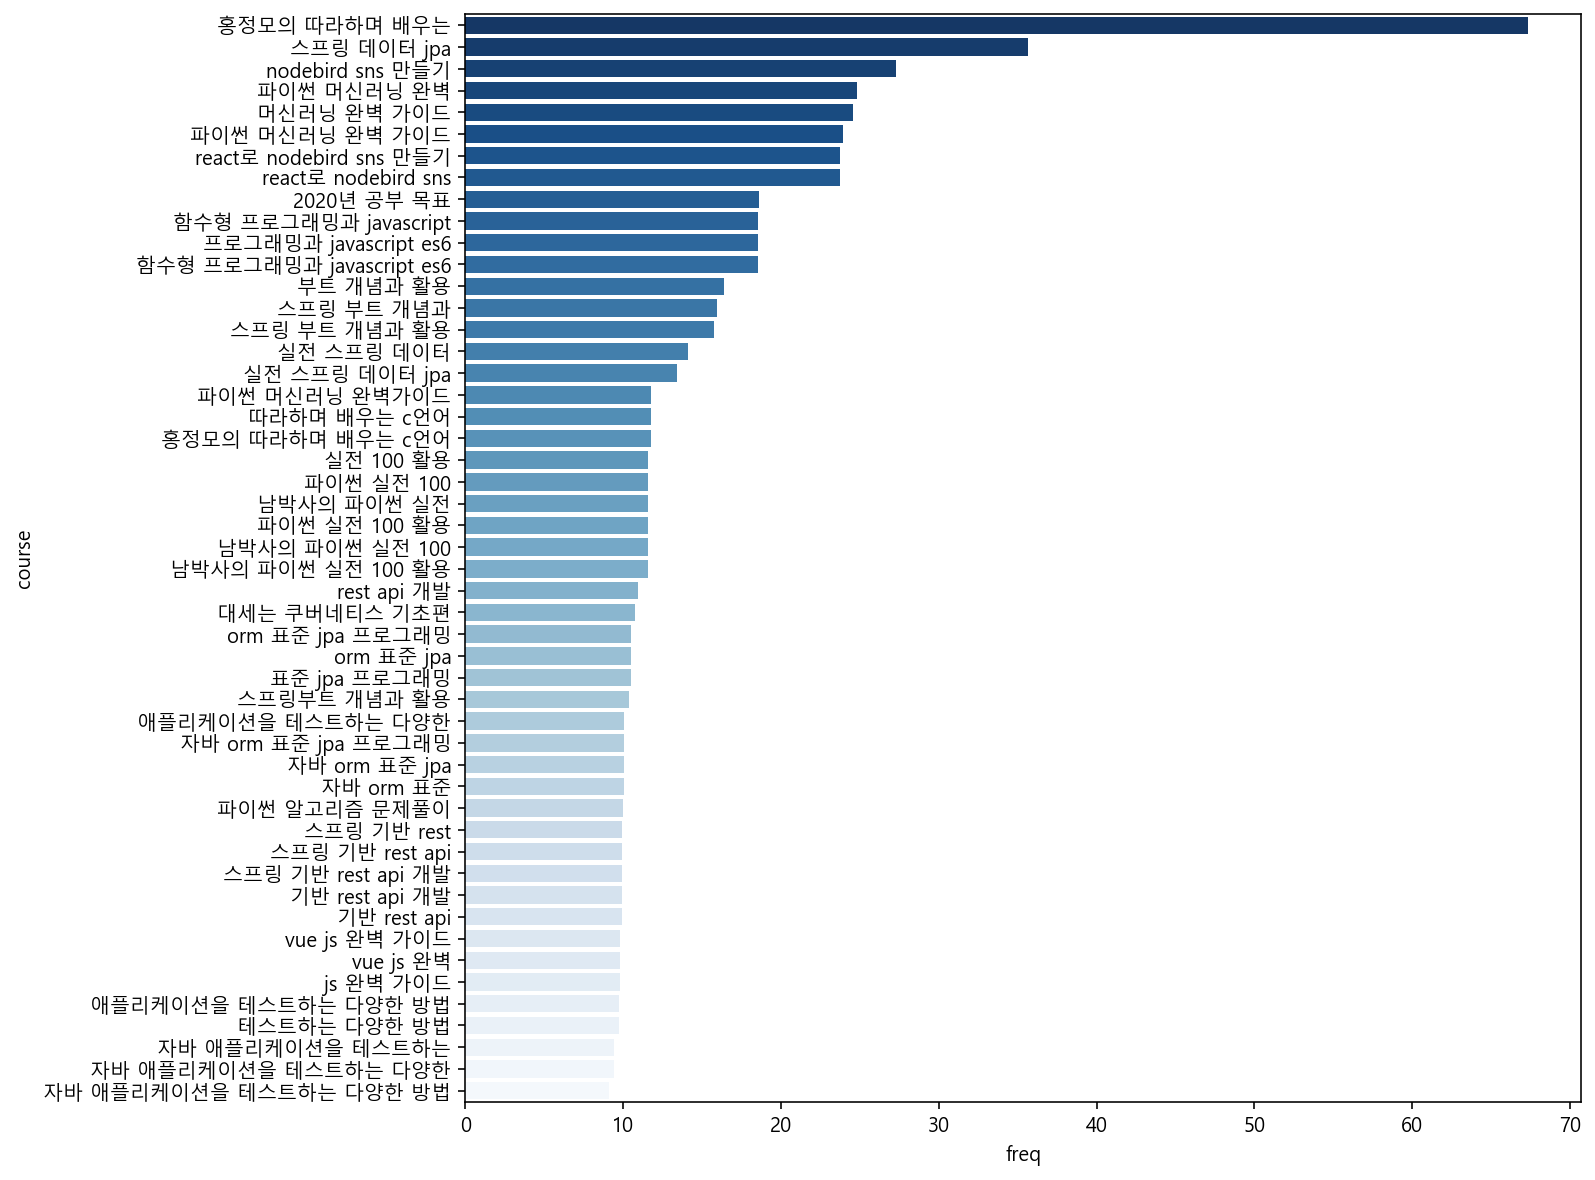

In [118]:
# 중간에 생략되는 단어를 자세히 보고자 할 때
# for문으로 출력해 봅니다.

import seaborn as sns
plt.figure(figsize=(10,10))
sns.barplot(data=df_tfidf, x='freq', y='course', palette='Blues_r')

## 군집화 
### KMeans
* [2.3. Clustering — scikit-learn 0.22.2 documentation](https://scikit-learn.org/stable/modules/clustering.html#k-means)

In [120]:
from sklearn.cluster import KMeans
from tqdm import trange
inertia = []

start = 30
end = 70

# 적절한 클러스터의 갯수를 알기 위해 inertia 값을 구함
# trange 를 통해 시작과 끝 값을 지정해 주면 진행 정도를 알 수 있습니다.
# 학습을 할 때는 feature_tfidf 값을 사용합니다.
# cls.inertia_ 값을 inertia 리스트에 저장합니다.
for k in trange(start, end):
    cls = KMeans(n_clusters=k, n_jobs=-1, random_state=42)
    cls.fit(feature_tfidf)
    inertia.append(cls.inertia_)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.67it/s]


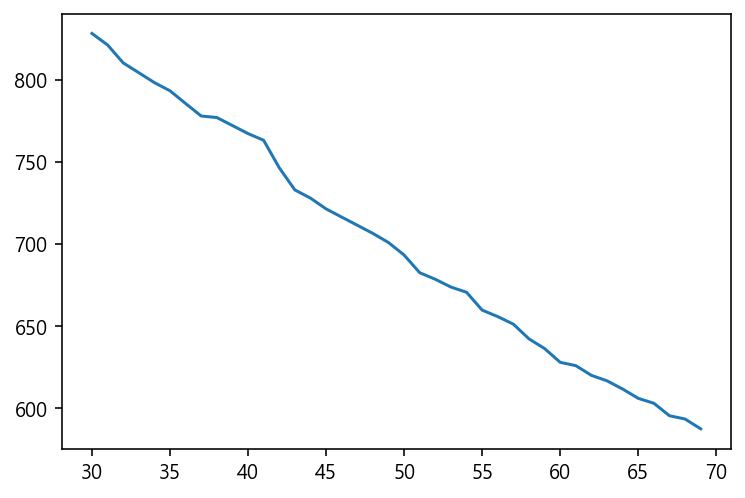

In [121]:
# 위에서 구한 값을 시각화 합니다.
# x축에는 클러스터의 수를 y축에는 inertia 값을 넣어 그립니다.


plt.plot(range(30, 70), inertia)

* 적정한 클러스터 갯수를 넣어 군집화 합니다.

In [122]:
# n_clusters 에 적절한 값을 넣어줍니다.
# fit.predict 를 하고 결과를 cluster 라는 새로운 컬럼에 담습니다.
k = 70
cls = KMeans(n_clusters=k, n_jobs=-1, random_state=42)
cls.fit(feature_tfidf)
predictions = cls.predict(feature_tfidf)
predictions.shape

(2411,)

In [123]:
# df["cluster"] 의 빈도수를 value_counts로 세어봅니다.

df['cluster'] = predictions

In [130]:
df['cluster'].value_counts().head(10)

1     1558
2       55
21      45
5       41
14      29
6       29
4       26
3       25
13      25
37      23
Name: cluster, dtype: int64

In [132]:
df.loc[df['cluster']==8, 'course']

125                  그로스해킹 - 데이터와 실험을 통해 성장하는 서비스를 만드는 방법
173                    그로스해킹-데이터와 실험을 통해 성장하는 서비스를 만드는 방법
176                  그로스해킹 - 데이터와 실험을 통해 성장하는 서비스를 만드는 방법
179                  그로스해킹 - 데이터와 실험을 통해 성장하는 서비스를 만드는 방법
192     파이썬데이터시각화 분석 실전 프로젝트 , 그로스해킹 - 데이터와 실험을 통해 성장하...
370                  그로스해킹 - 데이터와 실험을 통해 성장하는 서비스를 만드는 방법
384                  그로스해킹 - 데이터와 실험을 통해 성장하는 서비스를 만드는 방법
464                  그로스해킹 - 데이터와 실험을 통해 성장하는 서비스를 만드는 방법
698                  그로스해킹 - 데이터와 실험을 통해 성장하는 서비스를 만드는 방법
828     그로스해킹 - 데이터와 실험을 통해 성장하는 서비스를 만드는 방법, [NLP] IM...
859                  그로스해킹 - 데이터와 실험을 통해 성장하는 서비스를 만드는 방법
1006    1. 그로스해킹- 데이터와 실험을 통해 성장하는 서비스를 만드는 방법\n2. SQL...
1554    늘 목표만 잡고 안 지켜지는 나를 위해 간편한 규칙들을 준비하려 합니다.\n누군가에...
1592                 그로스해킹 - 데이터와 실험을 통해 성장하는 서비스를 만드는 방법
1743                  그로스해킹- 데이터와 실험을 통해 성장하는 서비스를 만드는 방법
2028                 그로스해킹 - 데이터와 실험을 통해 성장하는 서비스를 만드는 방법
2440                 그로스해킹 - 데이터와 실험을 통해 성장하는 서비스를 만드는 방법
Name: course, 

### MiniBatchKMeans
* [Comparison of the K-Means and MiniBatchKMeans clustering algorithms — scikit-learn 0.22.1 documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html)

In [133]:
# batch_size 를 쓸 수 있는 MiniBatchKMeans 로 군집화
from sklearn.cluster import MiniBatchKMeans
b_inertia = []

# 적절한 클러스터의 갯수를 알기 위해 inertia 값을 구함
# trange 를 통해 시작과 끝 값을 지정해 주면 진행 정도를 알 수 있습니다.
# b_inertia 리스트에 cls.inertia_ 값을 넣어줍니다.

for k in trange(start, end):
    minicls = MiniBatchKMeans(n_clusters=k, random_state=42)
    minicls.fit(feature_tfidf)
    b_inertia.append(minicls.inertia_)
b_inertia

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.87it/s]


[990.9980410189711,
 1018.1042474675928,
 1042.8901965703894,
 986.5367833030974,
 1017.6860489432296,
 933.5858934317528,
 944.808463581632,
 928.1218728695588,
 944.5277531807703,
 956.8050673446165,
 968.7832968048444,
 954.8083985500307,
 956.7693700261623,
 950.1332495237589,
 933.0594965523361,
 900.637479038778,
 935.9661509296794,
 867.8640883161352,
 898.5666032979198,
 908.6055290113676,
 925.3181291410705,
 894.1760507302096,
 916.5030401152525,
 896.9343140159024,
 917.9260822544405,
 856.3091852825104,
 826.0823925427659,
 804.6345971546128,
 845.0430555641576,
 830.250544993555,
 910.4430110361036,
 822.906780632396,
 876.3433526590196,
 812.3668352494951,
 837.4223890315446,
 804.7654289852112,
 821.7652356848887,
 820.2217612540175,
 864.2494057373558,
 825.2114531562745]

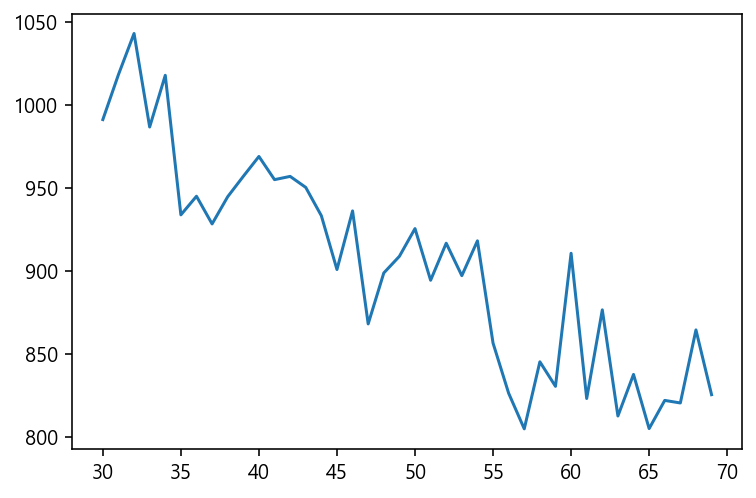

In [134]:
# 위에서 구한 값을 시각화 합니다.
# x축에는 클러스터의 수를 y축에는 b_inertia 값을 넣어 그립니다.

plt.plot(range(start,end),b_inertia)

In [146]:
# MiniBatchKMeans 를 통해 학습을 시킵니다.
# 결과를 bcluster 라는 변수에 저장합니다.

k=70
minicls = MiniBatchKMeans(n_clusters=k, random_state=42)
minicls.fit(feature_tfidf)
predictions = minicls.predict(feature_tfidf)
predictions.shape

(2411,)

In [147]:
# bcluster의 빈도수를 구합니다.

df['bcluster'] = predictions

In [148]:
# 어떤 강좌명이 있는지 특정 클러스터의 값을 봅니다.  
df['bcluster'].value_counts().head(20)

59    1111
1      312
7       81
23      53
11      44
10      40
18      36
52      36
9       33
34      32
30      29
2       29
17      28
53      23
20      22
62      22
67      22
4       20
61      19
15      17
Name: bcluster, dtype: int64

In [149]:
df.loc[df['bcluster']==4, 'course']

150                     실전! 스프링 부트와 JPA 활용1 - 웹 애플리케이션 개발
333                     실전! 스프링 부트와 JPA 활용1 - 웹 애플리케이션 개발
374                     실전! 스프링 부트와 JPA 활용1 - 웹 애플리케이션 개발
832                     실전! 스프링 부트와 JPA 활용1 - 웹 애플리케이션 개발
883                실전! 스프링 부트와 JPA 활용1 - 웹 애플리케이션 개발, JPA
918                     실전! 스프링 부트와 JPA 활용1 - 웹 애플리케이션 개발
1191                    실전! 스프링 부트와 JPA 활용1 - 웹 애플리케이션 개발
1214                    실전! 스프링 부트와 JPA 활용1 - 웹 애플리케이션 개발
1220                    실전! 스프링 부트와 JPA 활용1 - 웹 애플리케이션 개발
1242                    실전! 스프링 부트와 JPA 활용1 - 웹 애플리케이션 개발
1261                    실전! 스프링 부트와 JPA 활용1 - 웹 애플리케이션 개발
1308    현재 전공과 하고싶은 분야가 달라서 휴학 했지만 졸업은 해야하니 마음 잡고 복학 예...
1755    '2020년 공부 목표'\n- 현재 자바 강의를 수강하고 있는데, 더 열심히 공부해...
1795                    실전! 스프링 부트와 JPA 활용1 - 웹 애플리케이션 개발
2066                    실전! 스프링 부트와 JPA 활용1 - 웹 애플리케이션 개발
2250                    실전! 스프링 부트와 JPA 활용1 - 웹 애플리케이션 개발
2332                    실전! 스프링 부트와 JPA 활용1 - 웹 애플리케이션 개발
2396          

In [150]:
# bcluster, cluster, course 값을 미리보기 합니다.

df[['bcluster','cluster','course']]

,bcluster,cluster,course
0,43,1,2020년 목표 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 강...
1,64,1,"2020년 목표 C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는 ..."
2,1,1,2020년 목표 리액트 공부하기
3,59,1,40대 프로그래밍 시작! 우리를 위한 프로그래밍 파이썬 중급
4,59,1,2020년 목표 돌머리 비전공자가 멋진 전공자 되기!
...,...,...,...
2444,20,37,스프링 데이터 JPA
2445,53,3,스프링 부트 개념과 활용
2446,59,1,에펙 초보자도 만들 수 있는 유튜브 인트로 에프터이펙트 강좌
2447,31,38,파이썬 입문 및 웹 크롤링을 활용한 다양한 자동화 어플리케이션 제작하기


### 클러스터 예측 정확도 확인하기

In [154]:
n_clusters=70
# n_clusters 위에서 정의한 클러스터 수를 사용
feature_array = feature_vector.toarray()
# 예측한 클러스터의 유니크 값
labels = np.unique(predictions)
df_cluster_score = []
df_cluster = []
for label in labels:
    id_temp = np.where(predictions==label) # 예측한 값이 클러스터 번호와 매치 되는 것을 가져옴
    x_means = np.mean(feature_array[id_temp], axis = 0) # 클러스터의 평균 값을 구함
    sorted_means = np.argsort(x_means)[::-1][:n_clusters] # 값을 역순으로 정렬해서 클러스터 수 만큼 가져옴
    features = vectorizer.get_feature_names()
    best_features = [(features[i], x_means[i]) for i in sorted_means] 
    # 클러스터별 전체 스코어
    df_score = pd.DataFrame(best_features, columns = ['features', 'score'])
    df_cluster_score.append(df_score)
    # 클러스터 대표 키워드
    df_cluster.append(best_features[0])

In [155]:
# 개별 클러스터에서 점수가 가장 높은 단어를 추출 아래 점수가 클수록 예측 정확도가 높음
# MiniBatchKMeans 로 예측한 값 기준

df_c = pd.DataFrame(df_cluster)
df_c['label'] = labels
df_c.columns = ['course', 'score', 'label']
df_c

,course,score,label
0,웹게임을 만들며 배우는,0.312500,0
1,2020년 공부 목표,0.076923,1
2,파이썬 실전 100,1.000000,2
3,스프링부트 개념과 활용,1.000000,3
4,실전 스프링 부트와 jpa 활용1,1.000000,4
...,...,...,...
62,nodebird sns 만들기,0.687500,65
63,vue js 시작하기 age of,1.000000,66
64,홍정모의 따라하며 배우는,1.181818,67
65,화이트해커가 되기 위한,0.266667,68


In [157]:
# score 정확도가 1이 나온 클러스터를 찾아봄 - 같은 강좌끼리 묶였는지 확인 함

df_c[df_c['score']==1]

,course,score,label
2,파이썬 실전 100,1.0,2
3,스프링부트 개념과 활용,1.0,3
4,실전 스프링 부트와 jpa 활용1,1.0,4
5,ui 개발로 배워보는 순수,1.0,5
8,nodebird sns 만들기,1.0,8
12,파이썬 머신러닝 완벽,1.0,12
13,공공데이터로 파이썬 데이터 분석,1.0,13
14,초심자를 위한 리액트 핵심 강좌,1.0,14
15,기반 rest api 개발,1.0,15
16,홍정모의 따라하며 배우는,1.0,16


## WordCloud
* [amueller/word_cloud: A little word cloud generator in Python](https://github.com/amueller/word_cloud)
* 설치 방법 : [Wordcloud :: Anaconda Cloud](https://anaconda.org/conda-forge/wordcloud)

In [159]:
# 하나의 문서로 만들어줍니다.
text = ' '.join(df['course'])
text[:100]

'2020년 목표 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 강의  스프링 웹 MVC 2020년 목표 C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심'

In [181]:
# 불용어 - 자주 등장하지만 의미가 크지 않아 제외하고 싶은 텍스트
# stopwords = ["관심 강의", "관심강의", "관심", "강의", "강좌", "강의를",
#              "올해", "올해는", "열심히", "공부를", "합니다", "하고", "싶어요", 
#              "있는", "있습니다", "싶습니다", "2020년"]
# 불용어를 제거하지 않고 그리려면 아래 주석을 풀어서 stopword 변수에 덮어쓰기를 합니다.
stopwords = []
# displayWordCloud 라는 함수를 만들어 재사용합니다.
from wordcloud import WordCloud

def displayWordCloud(text, width=1500, height=700):    
    wordcloud = WordCloud(font_path="C:/Users/SWH/Downloads/Malgun Gothic.ttf",
                          width=1500, height=700,
                          stopwords = [],
                          background_color='white',
                          random_state=42).generate(text)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

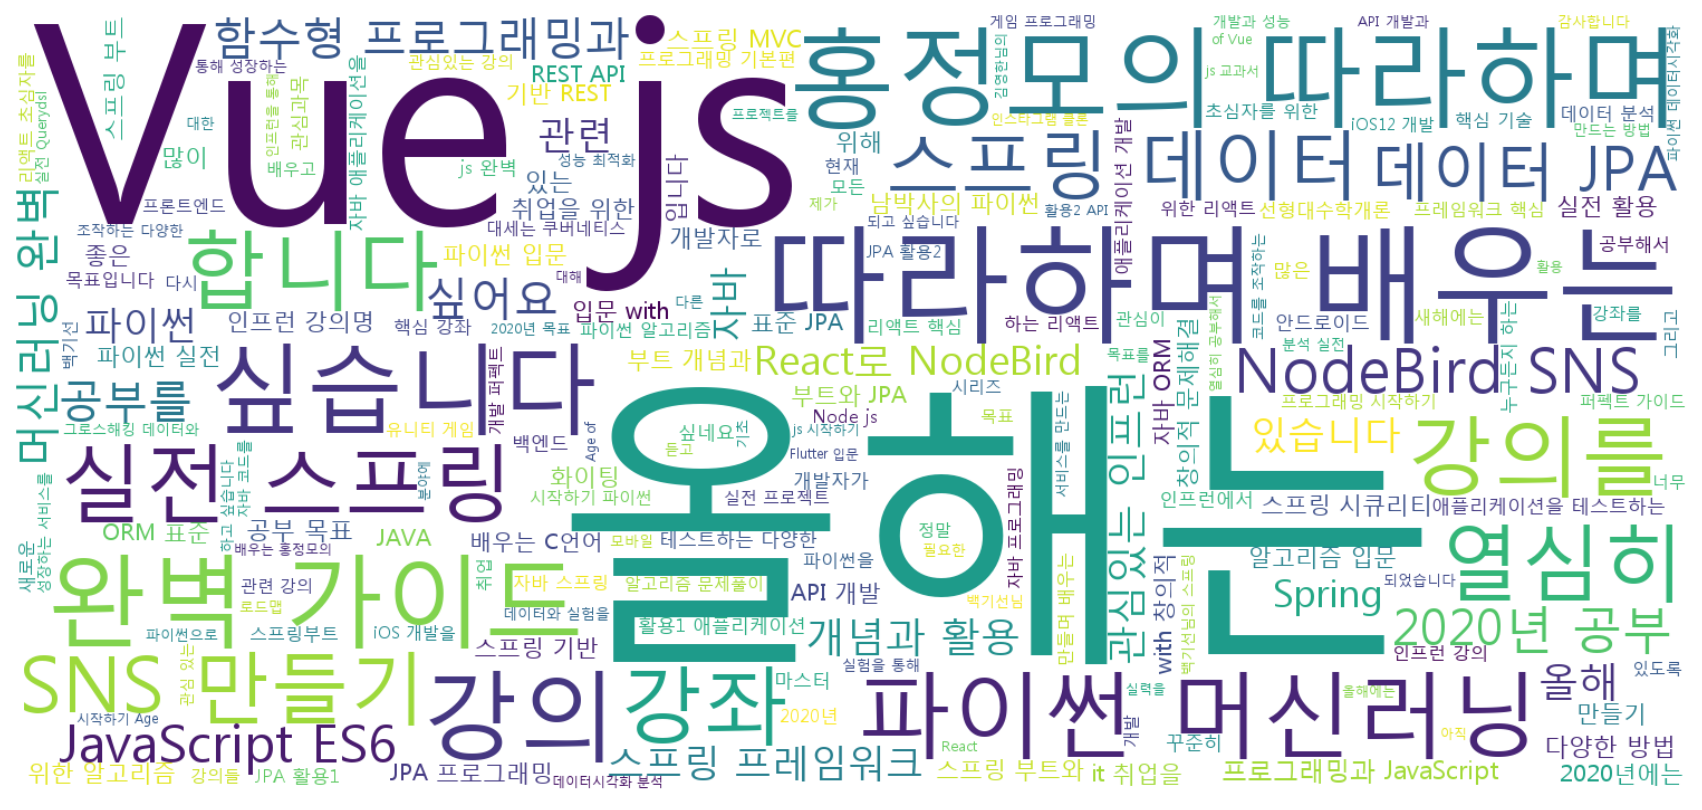

In [182]:
displayWordCloud(text, width=700, height=400)